In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from birdCLEFloaddata import load_audiofile,load_metadata,get_melspectrogram
from birdCLEFFunctions import Dynamic_CNN, Dynamic_CNN2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Grayscale, ToPILImage
import torchvision
import soundfile as sf
import random
import math
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

plt.rcParams['figure.dpi'] = 600

In [19]:
def load_metadata(directory,datadir, trim=False):
    if trim:
        df = pd.read_csv(directory+'/train_metadata_trim.csv')
    else:
        df = pd.read_csv(directory+'/train_metadata.csv')
    df['filename'] = datadir+"/train_audio/"+df['filename']
    chosen_coloumns = ['latitude', 'longitude', 'common_name', 'rating', 'filename']
    return df[chosen_coloumns]

path = r"D:\KU\Masters\AppML\APPML-BirdCLEF\data"
meta_data = load_metadata(path,path,trim=True)

# Load training and validation data

In [3]:
# Define the duration of each segment in seconds
segment_duration = 15
max_files_per_bird = 50

# Generate audio data
training_data = []
validation_data = []
birds_with_single_clip = []
random.seed(42)
# Iterate through each unique bird

for i, bird in enumerate(meta_data['common_name'].unique()):
    print(i+1, "/", len(meta_data['common_name'].unique()))
    # Get all audio clips for the bird
    bird_clips = meta_data[meta_data['common_name'] == bird]['filename'].tolist()
    # If the bird has only one clip, split it into two halves
    if len(bird_clips) == 1:
        birds_with_single_clip.append(bird)
    else:
        # Randomly select one clip for validation and the rest for training
        random.shuffle(bird_clips)
        training_clip = bird_clips[1:]
        validation_clip = bird_clips[0]

    # Load and process the training clip
    num_files_sampled = 0
    for clip in training_clip:
        if num_files_sampled >= max_files_per_bird:
            break
        train_audio, sr = load_audiofile(clip)
        num_segments = math.floor(len(train_audio) / (segment_duration * sr))
        if num_segments == 0:
          start_time = 0
          end_time = segment_duration
          pad_size = (segment_duration * sr) - train_audio.shape[0]
          train_audio = np.pad(train_audio, (0,pad_size), mode='wrap')
          segment_audio = train_audio[start_time * sr:end_time * sr]
          training_data.append([get_melspectrogram(segment_audio), bird])
        else:
          for segment in range(num_segments):
            start_time = segment * segment_duration
            end_time = start_time + segment_duration
            segment_audio = train_audio[start_time * sr:end_time * sr]
            training_data.append([get_melspectrogram(segment_audio), bird])
        num_files_sampled += 1

    # Load and process the validation clip
    validation_audio, sr = load_audiofile(validation_clip)
    num_segments = math.floor(len(validation_audio) / (segment_duration * sr))
    if num_segments == 0:
      start_time = 0
      end_time = segment_duration
      pad_size = (segment_duration * sr) - validation_audio.shape[0]
      validation_audio = np.pad(validation_audio, (0,pad_size), mode='wrap')
      segment_audio = validation_audio[start_time * sr:end_time * sr]
      validation_data.append([get_melspectrogram(segment_audio), bird])
    else:
      for segment in range(num_segments):
        start_time = segment * segment_duration
        end_time = start_time + segment_duration
        segment_audio = validation_audio[start_time * sr:end_time * sr]
        validation_data.append([get_melspectrogram(segment_audio), bird])

# Split the single clips into training and validation
random.shuffle(birds_with_single_clip)
split_index = len(birds_with_single_clip) // 2
training_single_clips = birds_with_single_clip[split_index:]
validation_single_clips = birds_with_single_clip[:split_index]

# Append the single clips to the training and validation data
for bird in birds_with_single_clip:
    if len(training_data) >= max_files_per_bird:
        break
    clip = meta_data[meta_data['common_name'] == bird]['filename'].tolist()[0]
    audio, sr = load_audiofile(clip)
    num_segments = math.floor(len(audio) / (segment_duration * sr))
    if num_segments == 0:
      start_time = 0
      end_time = segment_duration
      pad_size = (segment_duration * sr) - validation_audio.shape[0]
      validation_audio = np.pad(validation_audio, (0,pad_size), mode='wrap')
      segment_audio = validation_audio[start_time * sr:end_time * sr]
      validation_data.append([get_melspectrogram(segment_audio), bird])
      training_data.append([get_melspectrogram(segment_audio), bird])
    else:
      for segment in range(num_segments):
        start_time = segment * segment_duration
        end_time = start_time + segment_duration
        segment_audio = audio[start_time * sr:end_time * sr]
        validation_data.append([get_melspectrogram(segment_audio), bird])
        training_data.append([get_melspectrogram(segment_audio), bird])

# Convert to numpy arrays
training_data = np.asarray(training_data)
validation_data = np.asarray(validation_data)

# Map labels to indices
label_mapping = {label: index for index, label in enumerate(set(meta_data['common_name'].unique()))}
training_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in training_data[:, 1]]
validation_data[:, 1] = [label_mapping.get(label, -1) + 1 for label in validation_data[:, 1]]

# Clear temporary data and variables
birds_with_single_clip = None
training_single_clips = None
validation_single_clips = None

1 / 264
2 / 264
3 / 264
4 / 264
5 / 264
6 / 264
7 / 264
8 / 264
9 / 264
10 / 264
11 / 264
12 / 264
13 / 264
14 / 264
15 / 264
16 / 264
17 / 264
18 / 264
19 / 264
20 / 264
21 / 264
22 / 264
23 / 264
24 / 264
25 / 264
26 / 264
27 / 264
28 / 264
29 / 264
30 / 264
31 / 264
32 / 264
33 / 264
34 / 264
35 / 264
36 / 264
37 / 264
38 / 264
39 / 264
40 / 264
41 / 264
42 / 264
43 / 264
44 / 264
45 / 264
46 / 264
47 / 264
48 / 264
49 / 264
50 / 264
51 / 264
52 / 264
53 / 264
54 / 264
55 / 264
56 / 264
57 / 264
58 / 264
59 / 264
60 / 264
61 / 264
62 / 264
63 / 264
64 / 264
65 / 264
66 / 264
67 / 264
68 / 264
69 / 264
70 / 264
71 / 264
72 / 264
73 / 264
74 / 264
75 / 264
76 / 264
77 / 264
78 / 264
79 / 264
80 / 264
81 / 264
82 / 264
83 / 264
84 / 264
85 / 264
86 / 264
87 / 264
88 / 264
89 / 264
90 / 264
91 / 264
92 / 264
93 / 264
94 / 264
95 / 264
96 / 264
97 / 264
98 / 264
99 / 264
100 / 264
101 / 264
102 / 264
103 / 264
104 / 264
105 / 264
106 / 264
107 / 264
108 / 264
109 / 264
110 / 264
111 / 26

C:\Users\Birk Dissing\AppData\Local\Temp\ipykernel_28508\3869054807.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  training_data = np.asarray(training_data)
C:\Users\Birk Dissing\AppData\Local\Temp\ipykernel_28508\3869054807.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.asarray(training_data)
C:\Users\Birk Dissing\AppData\Local\Temp\i

# ROC curve

In [4]:
val_probabilities = np.load('val_probabilities.npy')
val_true_labels = np.load('val_true_labels.npy')

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


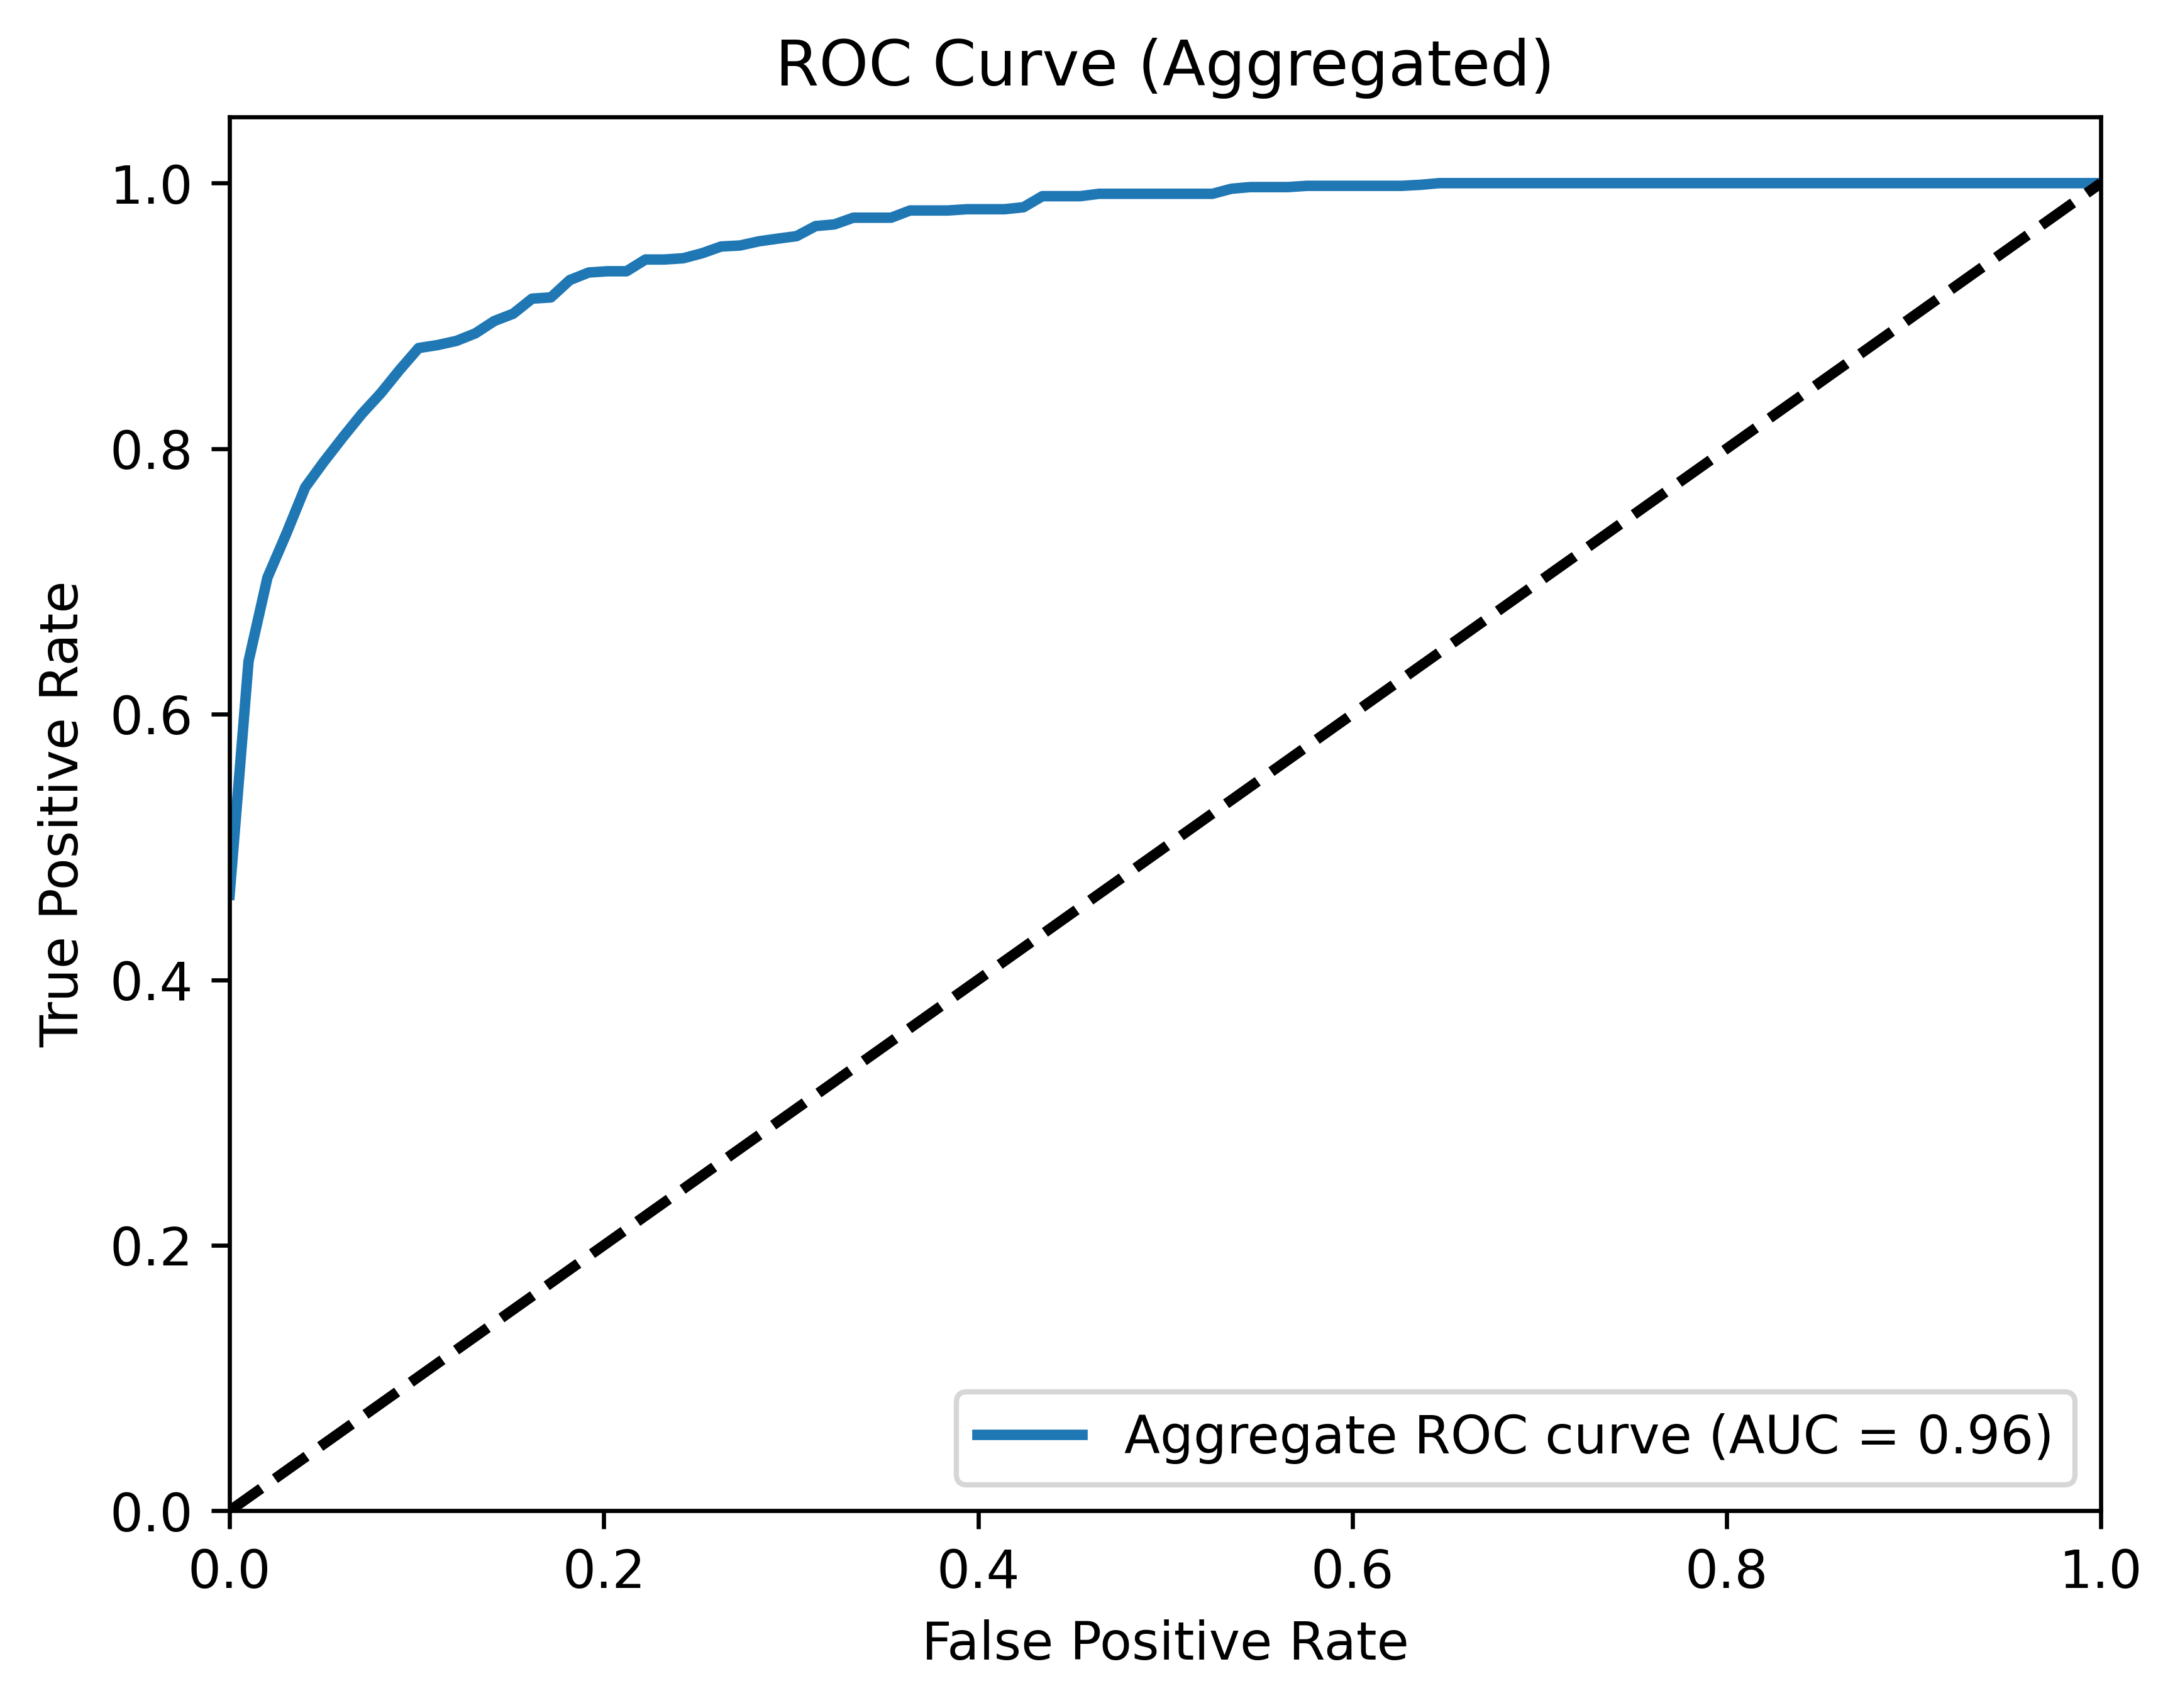

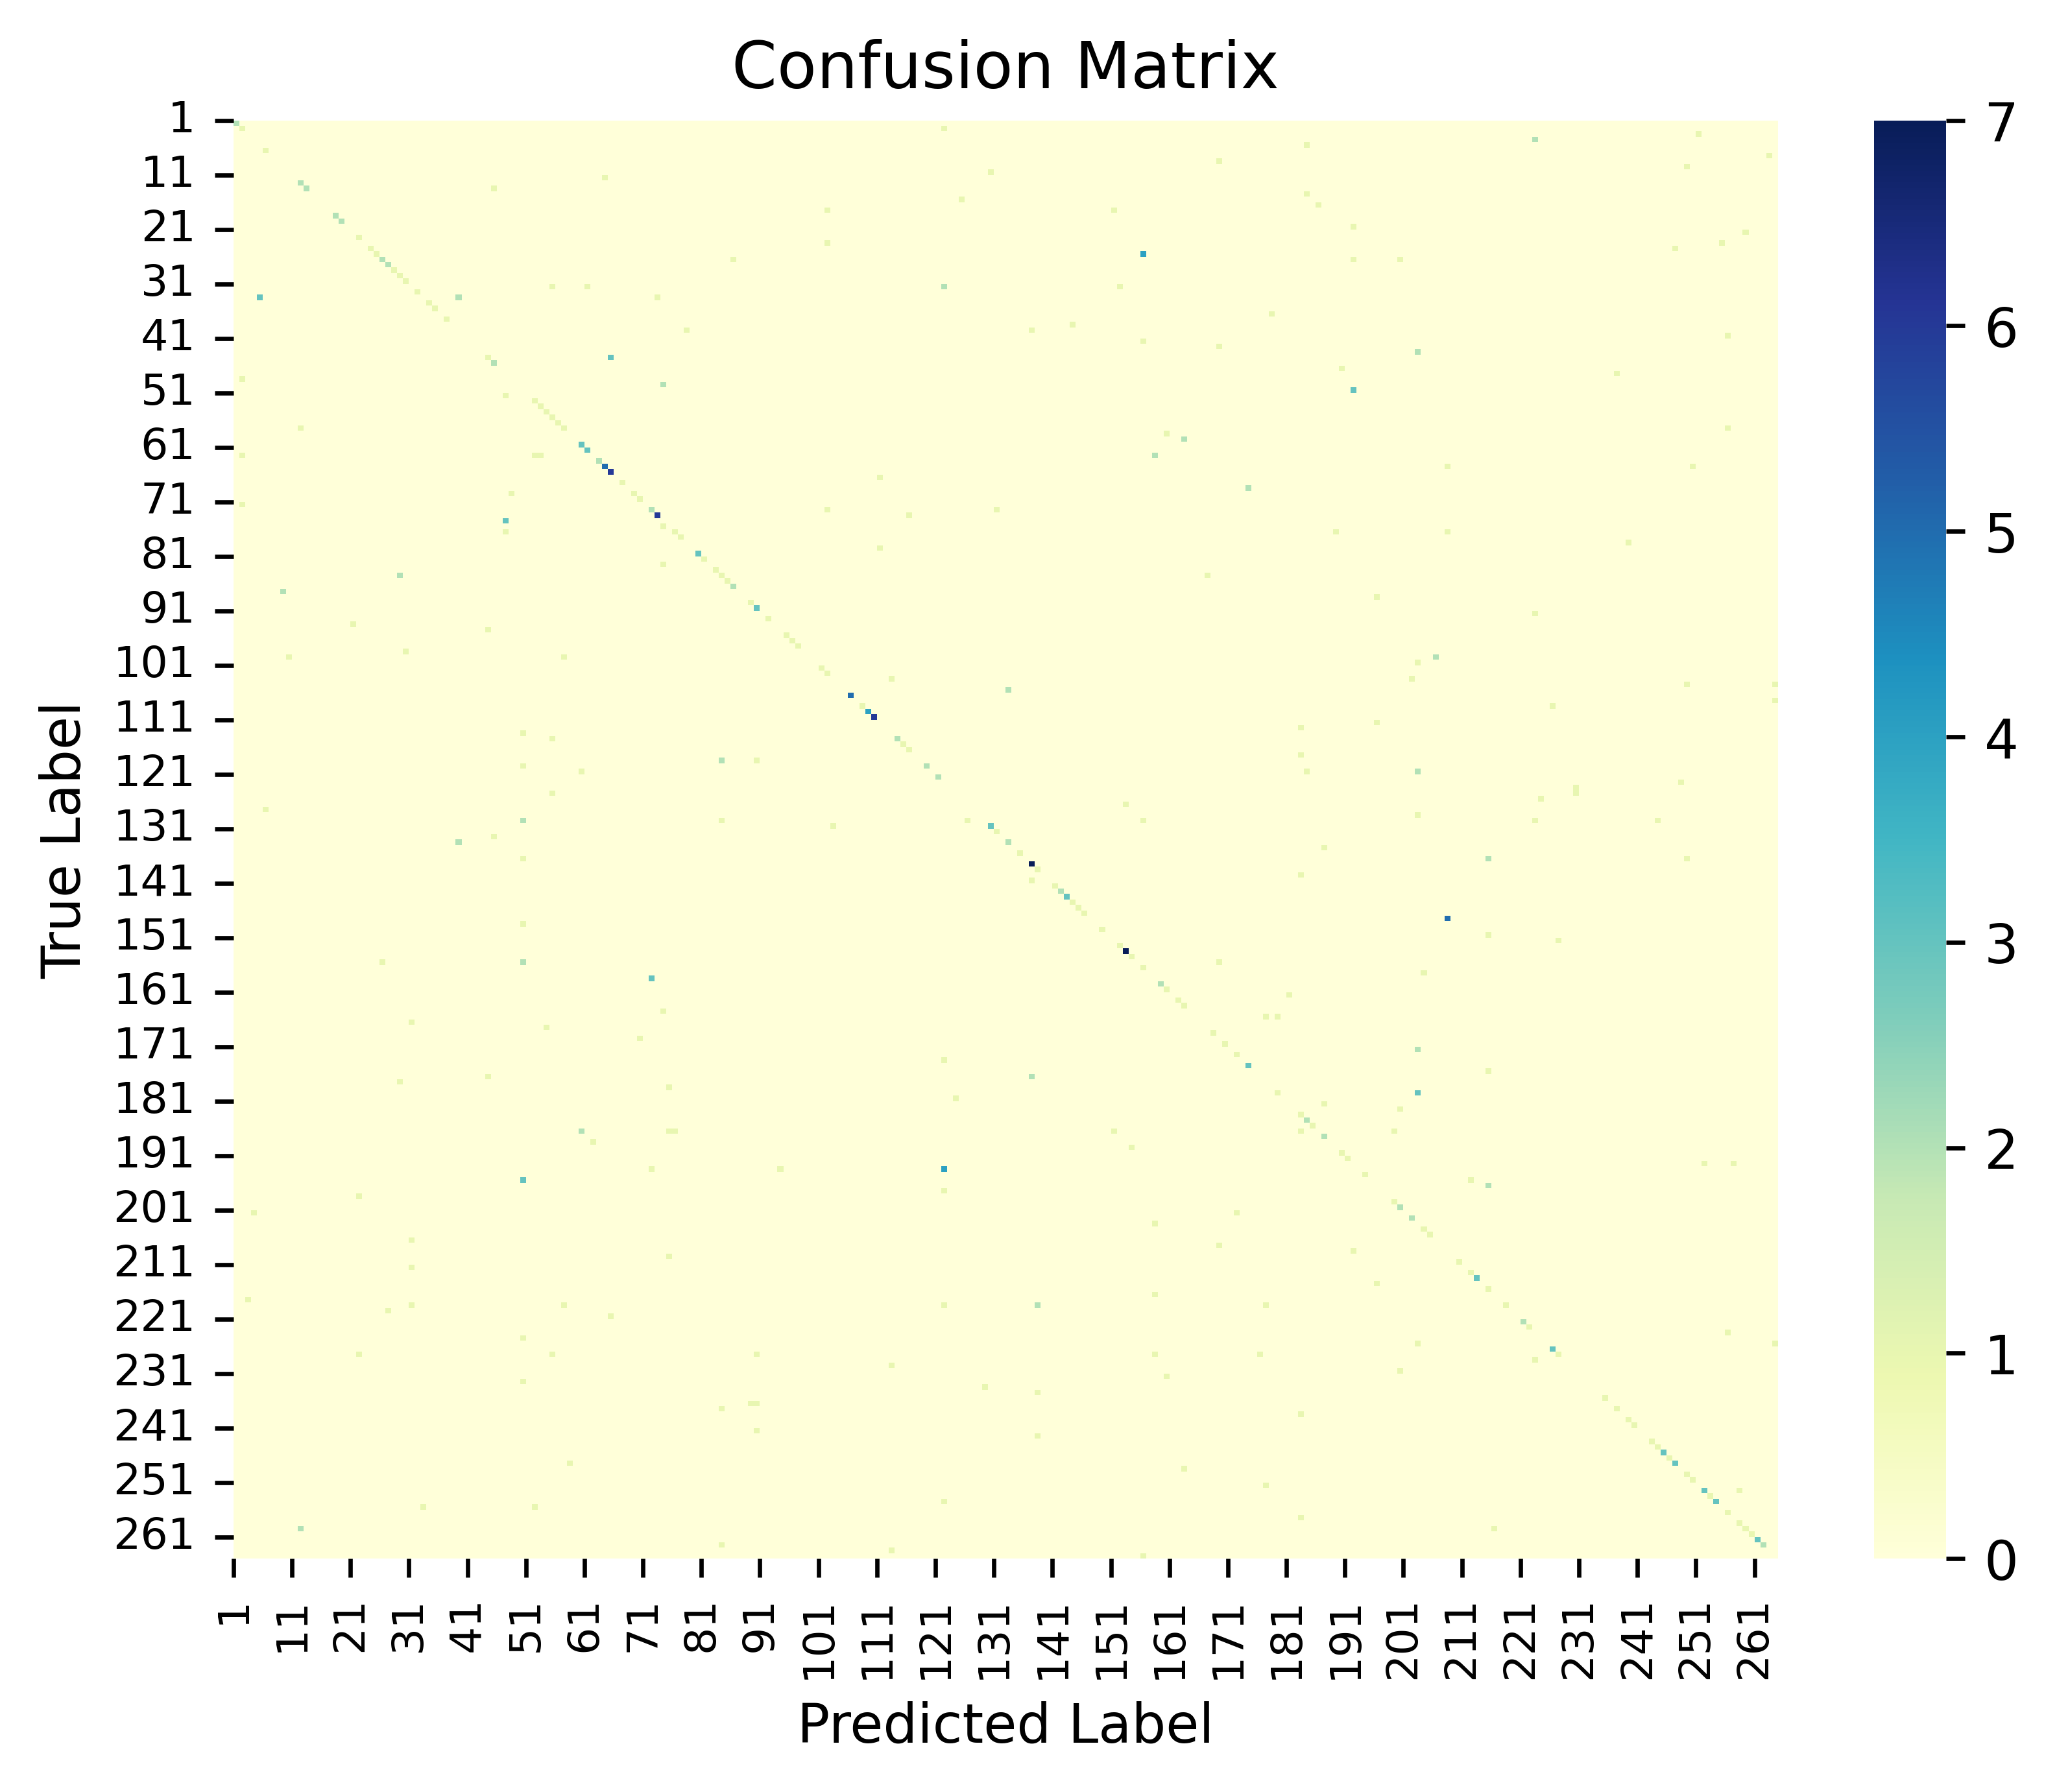

In [7]:
val_predictions = np.argmax(val_probabilities, axis=1)
# Compute and print the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
print("Confusion Matrix:")
print(cm)

unique_classes = np.unique(validation_data[:, 1])
target_names = np.unique(validation_data[:,1])

# Compute ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_id in unique_classes:
    # Create a binary target for the current class
    binary_labels = np.where(val_true_labels == class_id, 1, 0)

    # Calculate the ROC curve and AUC for the current class
    fpr[class_id], tpr[class_id], _ = roc_curve(binary_labels, val_probabilities[:, class_id])
    roc_auc[class_id] = auc(fpr[class_id], tpr[class_id])

# Aggregate TPR and FPR for all classes
all_tpr = np.concatenate([tpr[class_id] for class_id in unique_classes])
mean_fpr = np.linspace(0, 1, 100)

# Compute the mean TPR by interpolating at the mean FPR
mean_tpr = np.zeros_like(mean_fpr)
for class_id in unique_classes:
    mean_tpr += np.interp(mean_fpr, fpr[class_id], tpr[class_id])

mean_tpr /= len(unique_classes)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot the aggregated ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, lw=2, label='Aggregate ROC curve (AUC = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Aggregated)')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plt.figure()
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="YlGnBu")
ax.set_title('Confusion Matrix')
tick_frequency = 10
x_tick_locs = np.arange(len(unique_classes))
x_tick_labels = unique_classes
plt.xticks(ticks=x_tick_locs[::tick_frequency], labels=x_tick_labels[::tick_frequency], fontsize=8, rotation=90)
y_tick_locs = np.arange(len(unique_classes))
y_tick_labels = unique_classes
plt.yticks(ticks=y_tick_locs[::tick_frequency], labels=y_tick_labels[::tick_frequency], fontsize=8)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Correlation

In [22]:
total_time = np.load('total_time.npy', allow_pickle='TRUE').item() 
avg_rating = np.load('avg_rating.npy', allow_pickle='TRUE').item()
avg_time = np.load('avg_time.npy', allow_pickle='TRUE').item()
bird_accuracy = np.load('bird_accuracy.npy', allow_pickle='TRUE').item()

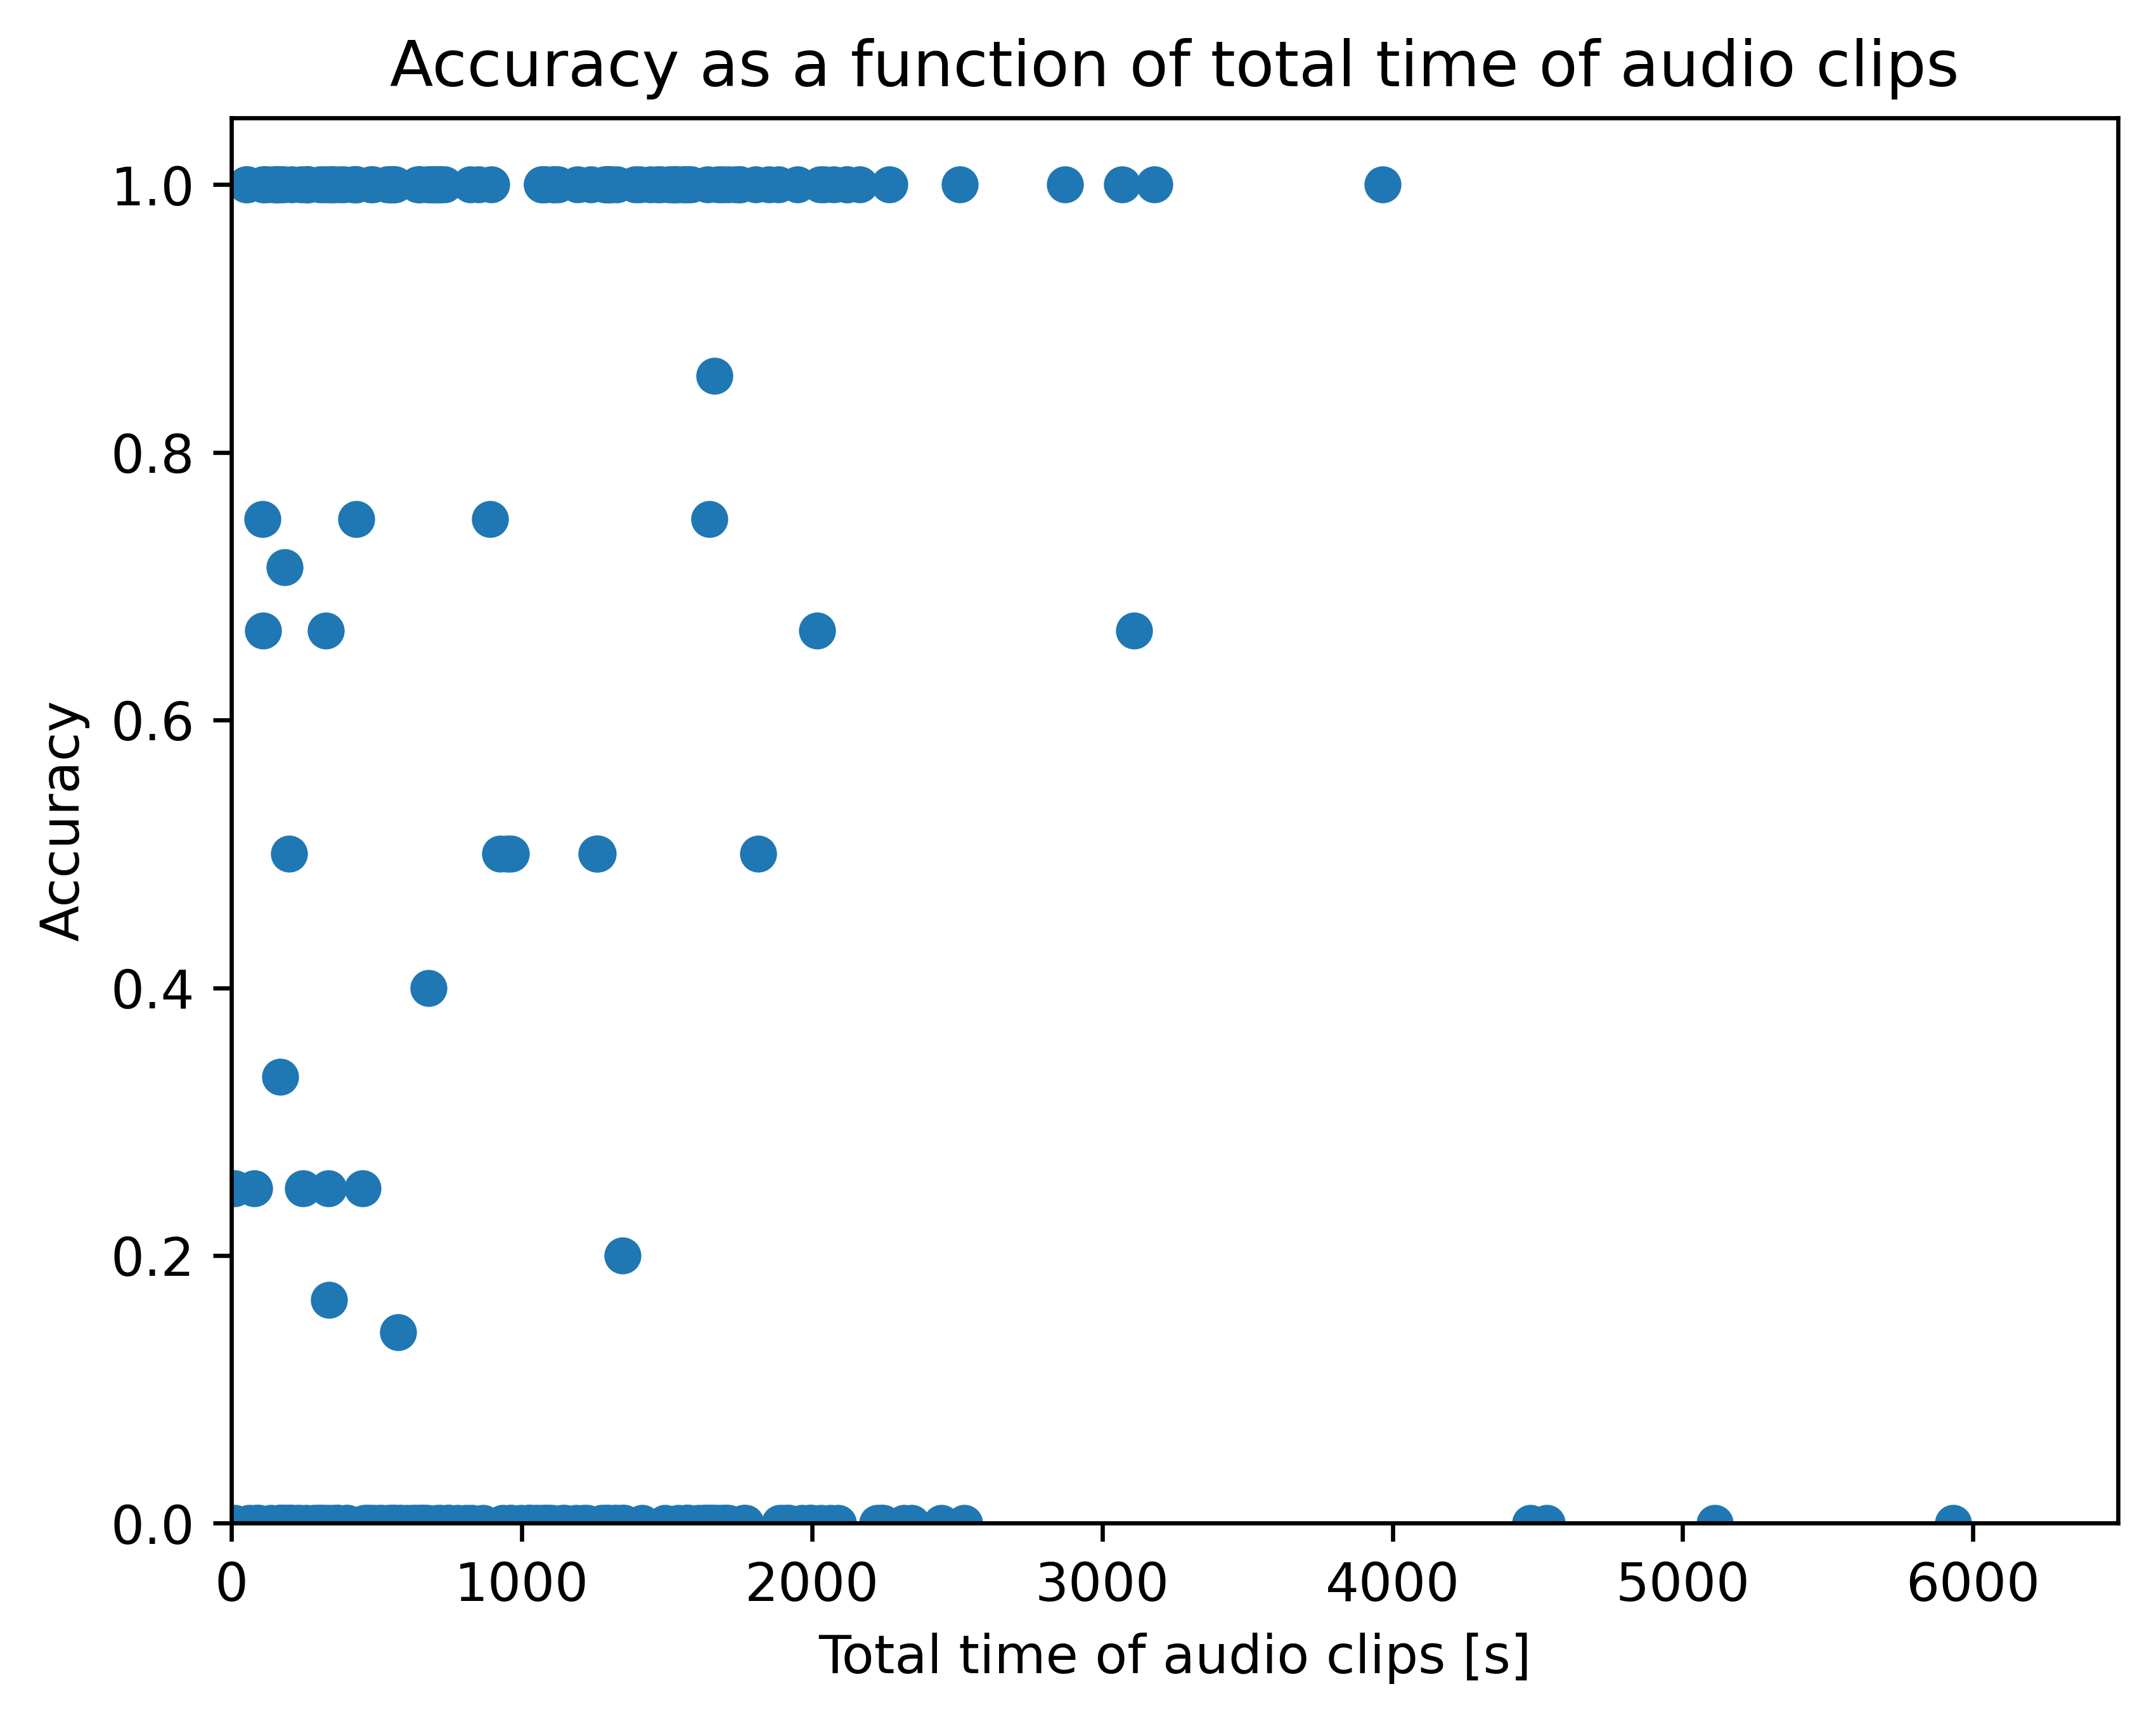

In [28]:
bird_accuracy_plot = []
total_time_plot = []
avg_rating_plot = []
avg_time_plot = []
for key in bird_accuracy:
    bird_accuracy_plot.append(bird_accuracy[key])
    total_time_plot.append(total_time[key])
    avg_rating_plot.append(avg_rating[key])
    avg_time_plot.append(avg_time[key])

#Plotting total_time and accuracy
plt.figure()
plt.scatter(total_time_plot, bird_accuracy_plot)
plt.xlim([0.0, 6500])
plt.ylim([0.0, 1.05])
plt.xlabel('Total time of audio clips [s]')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of total time of audio clips')
plt.show()

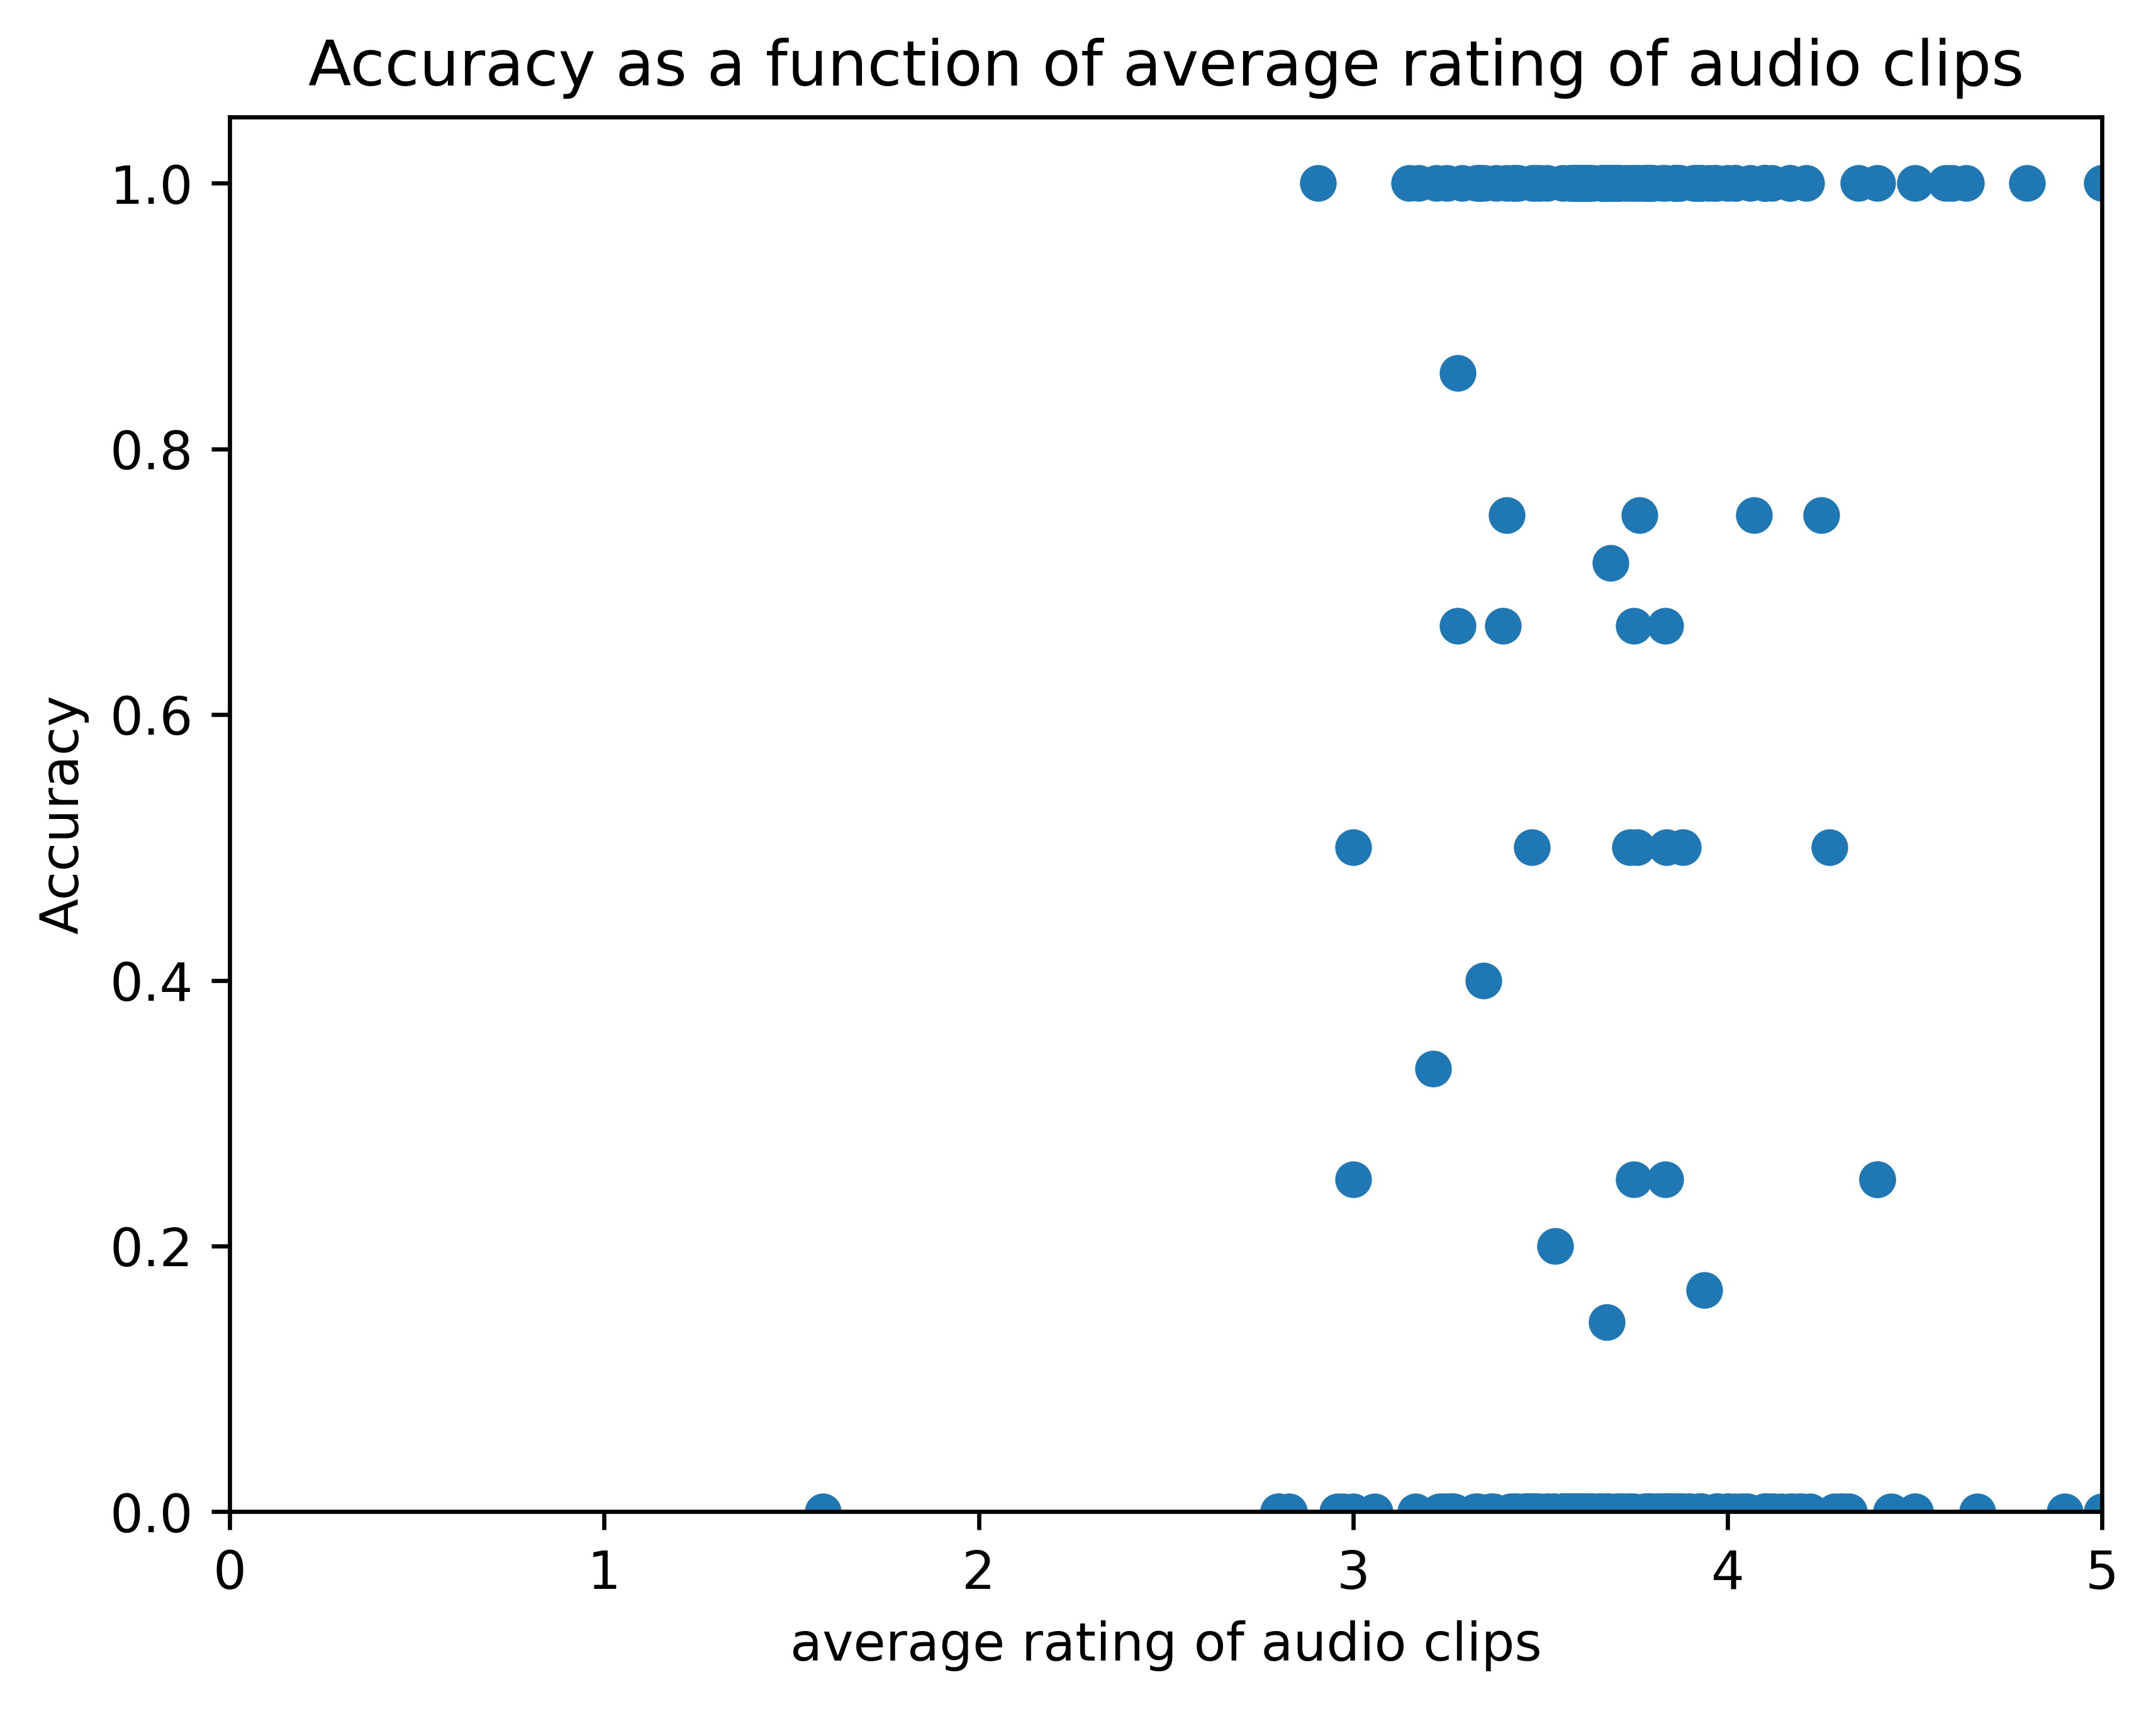

In [20]:
#Plotting average rating and accuracy
plt.figure()
plt.scatter(avg_rating_plot, bird_accuracy_plot)
plt.xlim([0.0, 5])
plt.ylim([0.0, 1.05])
plt.xlabel('Average rating of audio clips')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of average rating of audio clips')
plt.show()

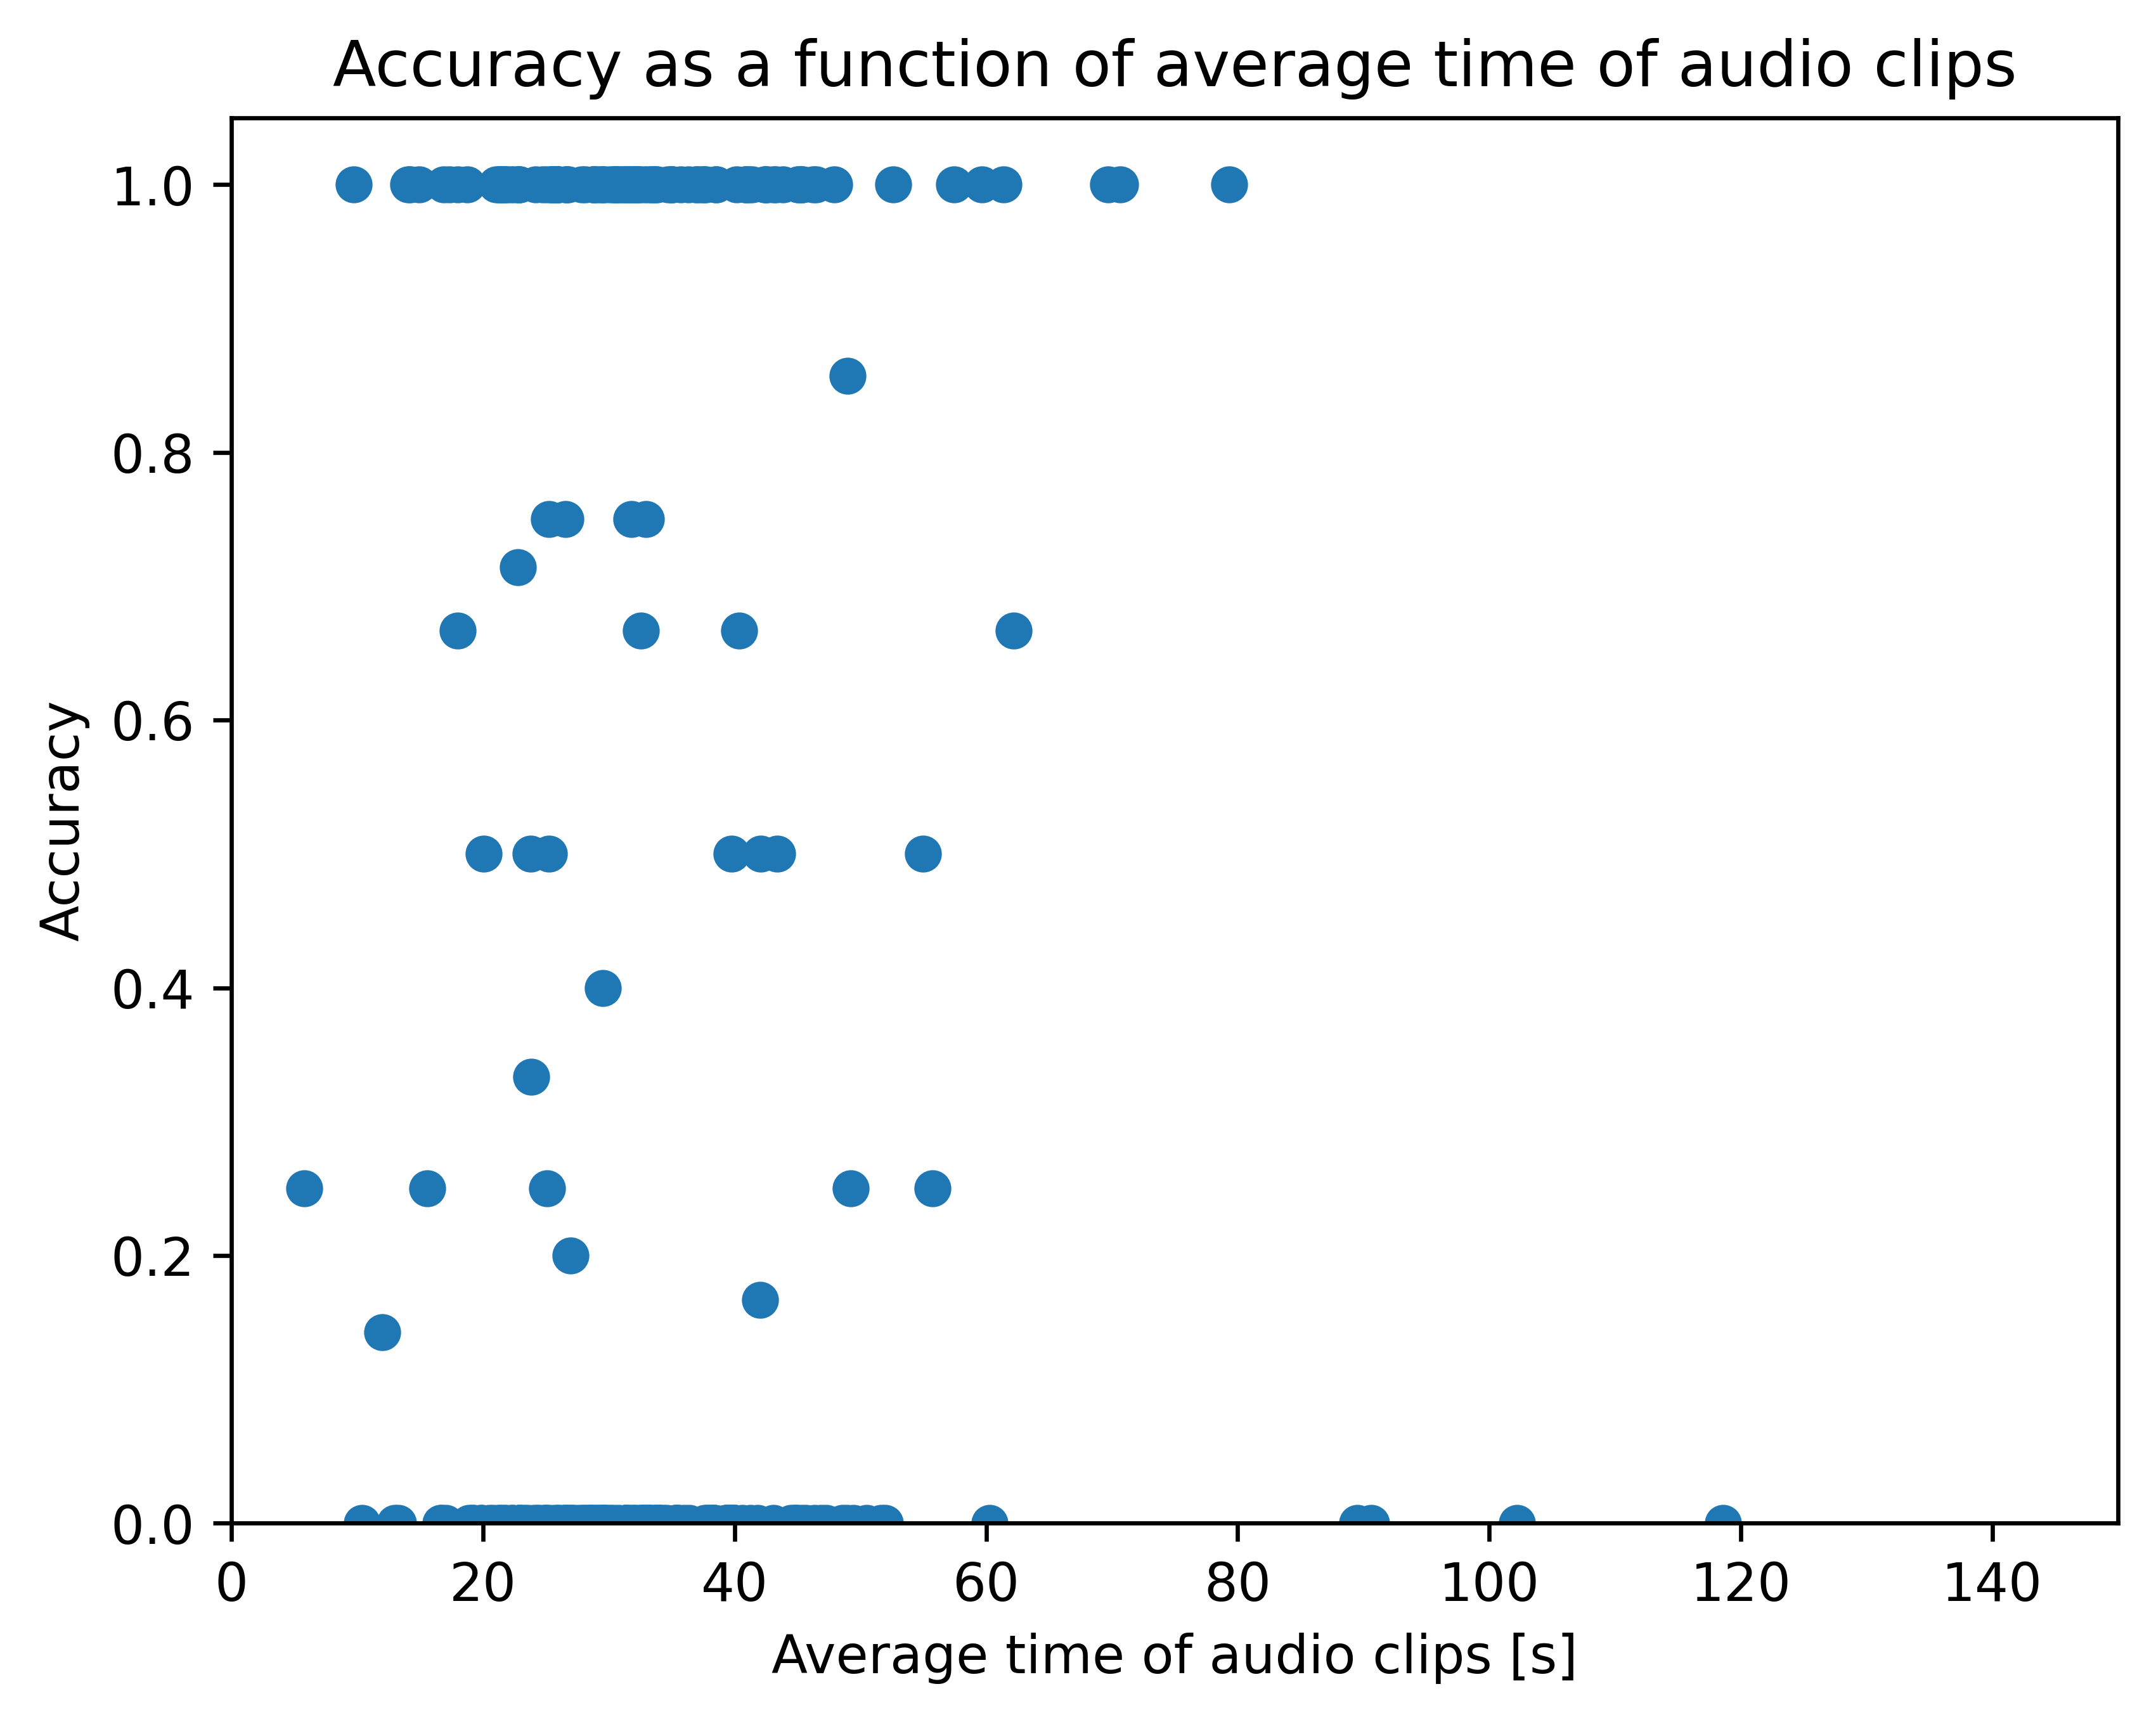

In [29]:
#Plotting average time and accuracy
plt.figure()
plt.scatter(avg_time_plot, bird_accuracy_plot)
plt.xlim([0.0, 150])
plt.ylim([0.0, 1.05])
plt.xlabel('Average time of audio clips [s]')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of average time of audio clips')
plt.show()

# Depiction of audio files

In [33]:
index = 67
meta_data = load_metadata(path,path,trim=True)
audio, sr = load_audiofile(meta_data['filename'][index])
print(len(audio)/sr)
meta_data = meta_data[meta_data['filename'] == meta_data['filename'][index]]
meta_data['filename'] = 'train_audio/XC118188.ogg'
meta_data.head(1)



39.024


,latitude,longitude,common_name,rating,filename
67,-25.3071,27.449,Chinspot Batis,3.5,train_audio/XC118188.ogg


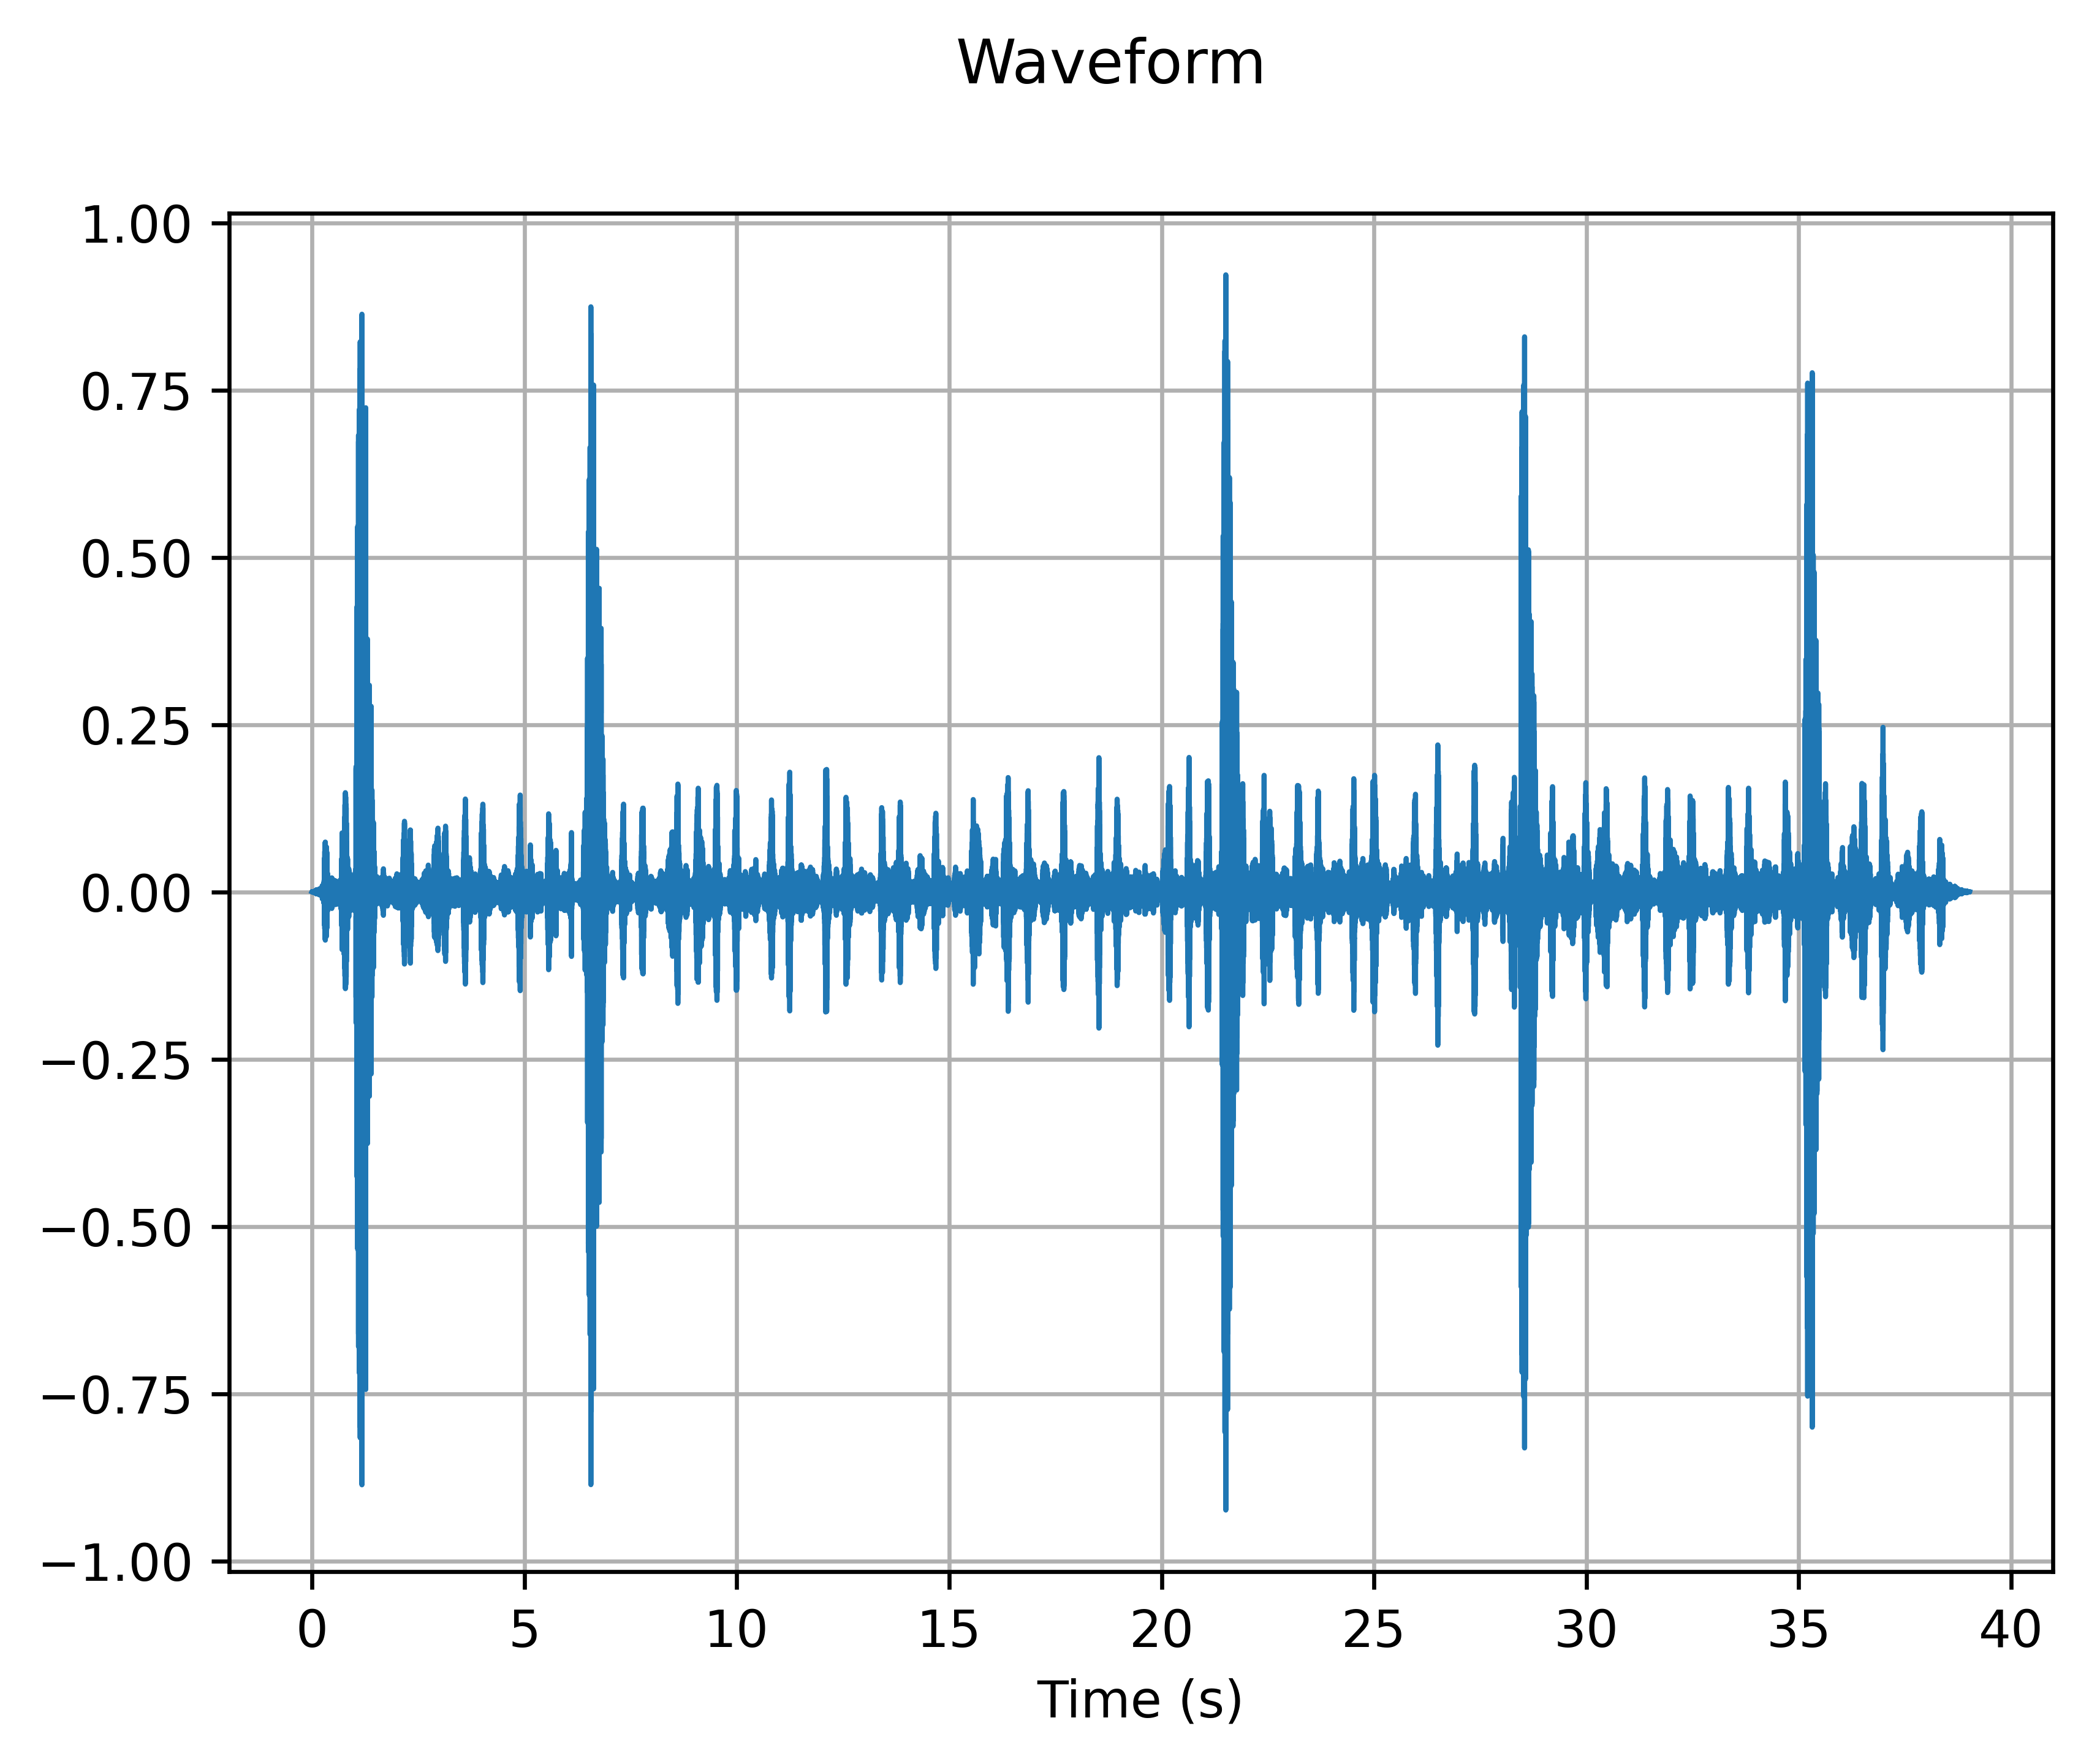

In [38]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = 1, waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    figure.suptitle("Waveform")
    plt.show(block=False)
plot_waveform(torch.from_numpy(audio), sr)

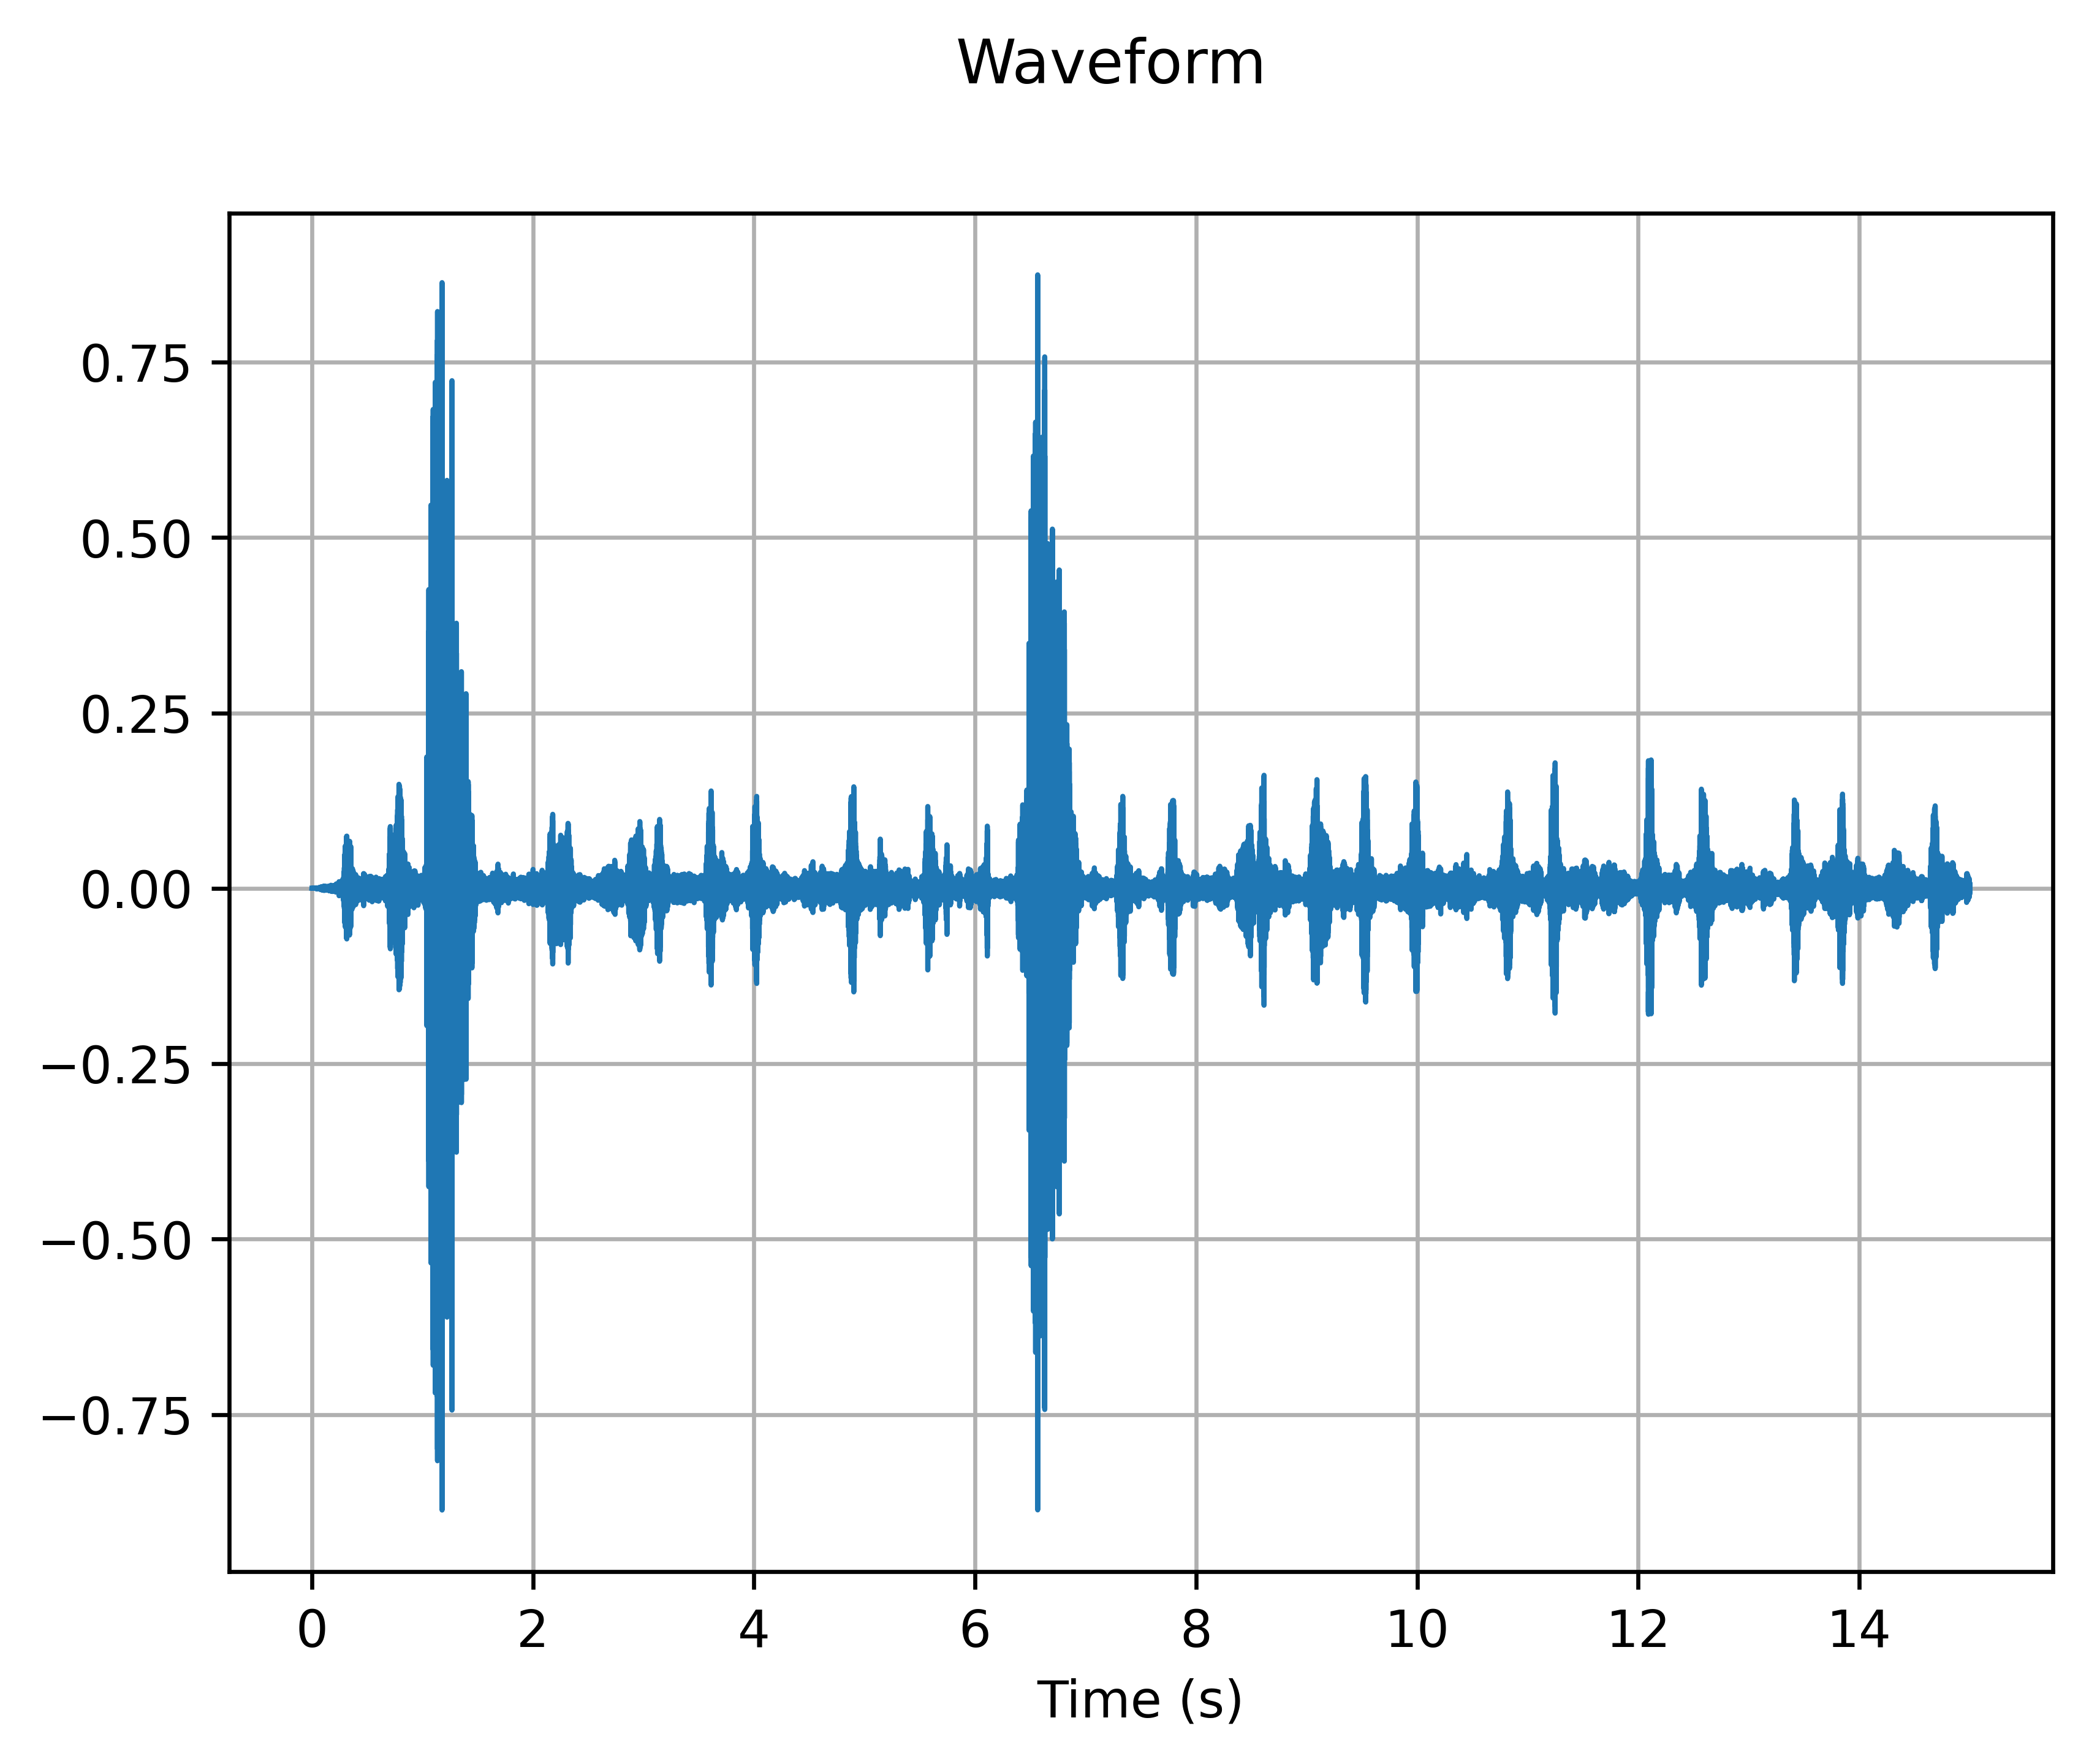

In [60]:
endtime = 15*sr
audio_15 = audio[:endtime]

plot_waveform(torch.from_numpy(audio_15), sr)

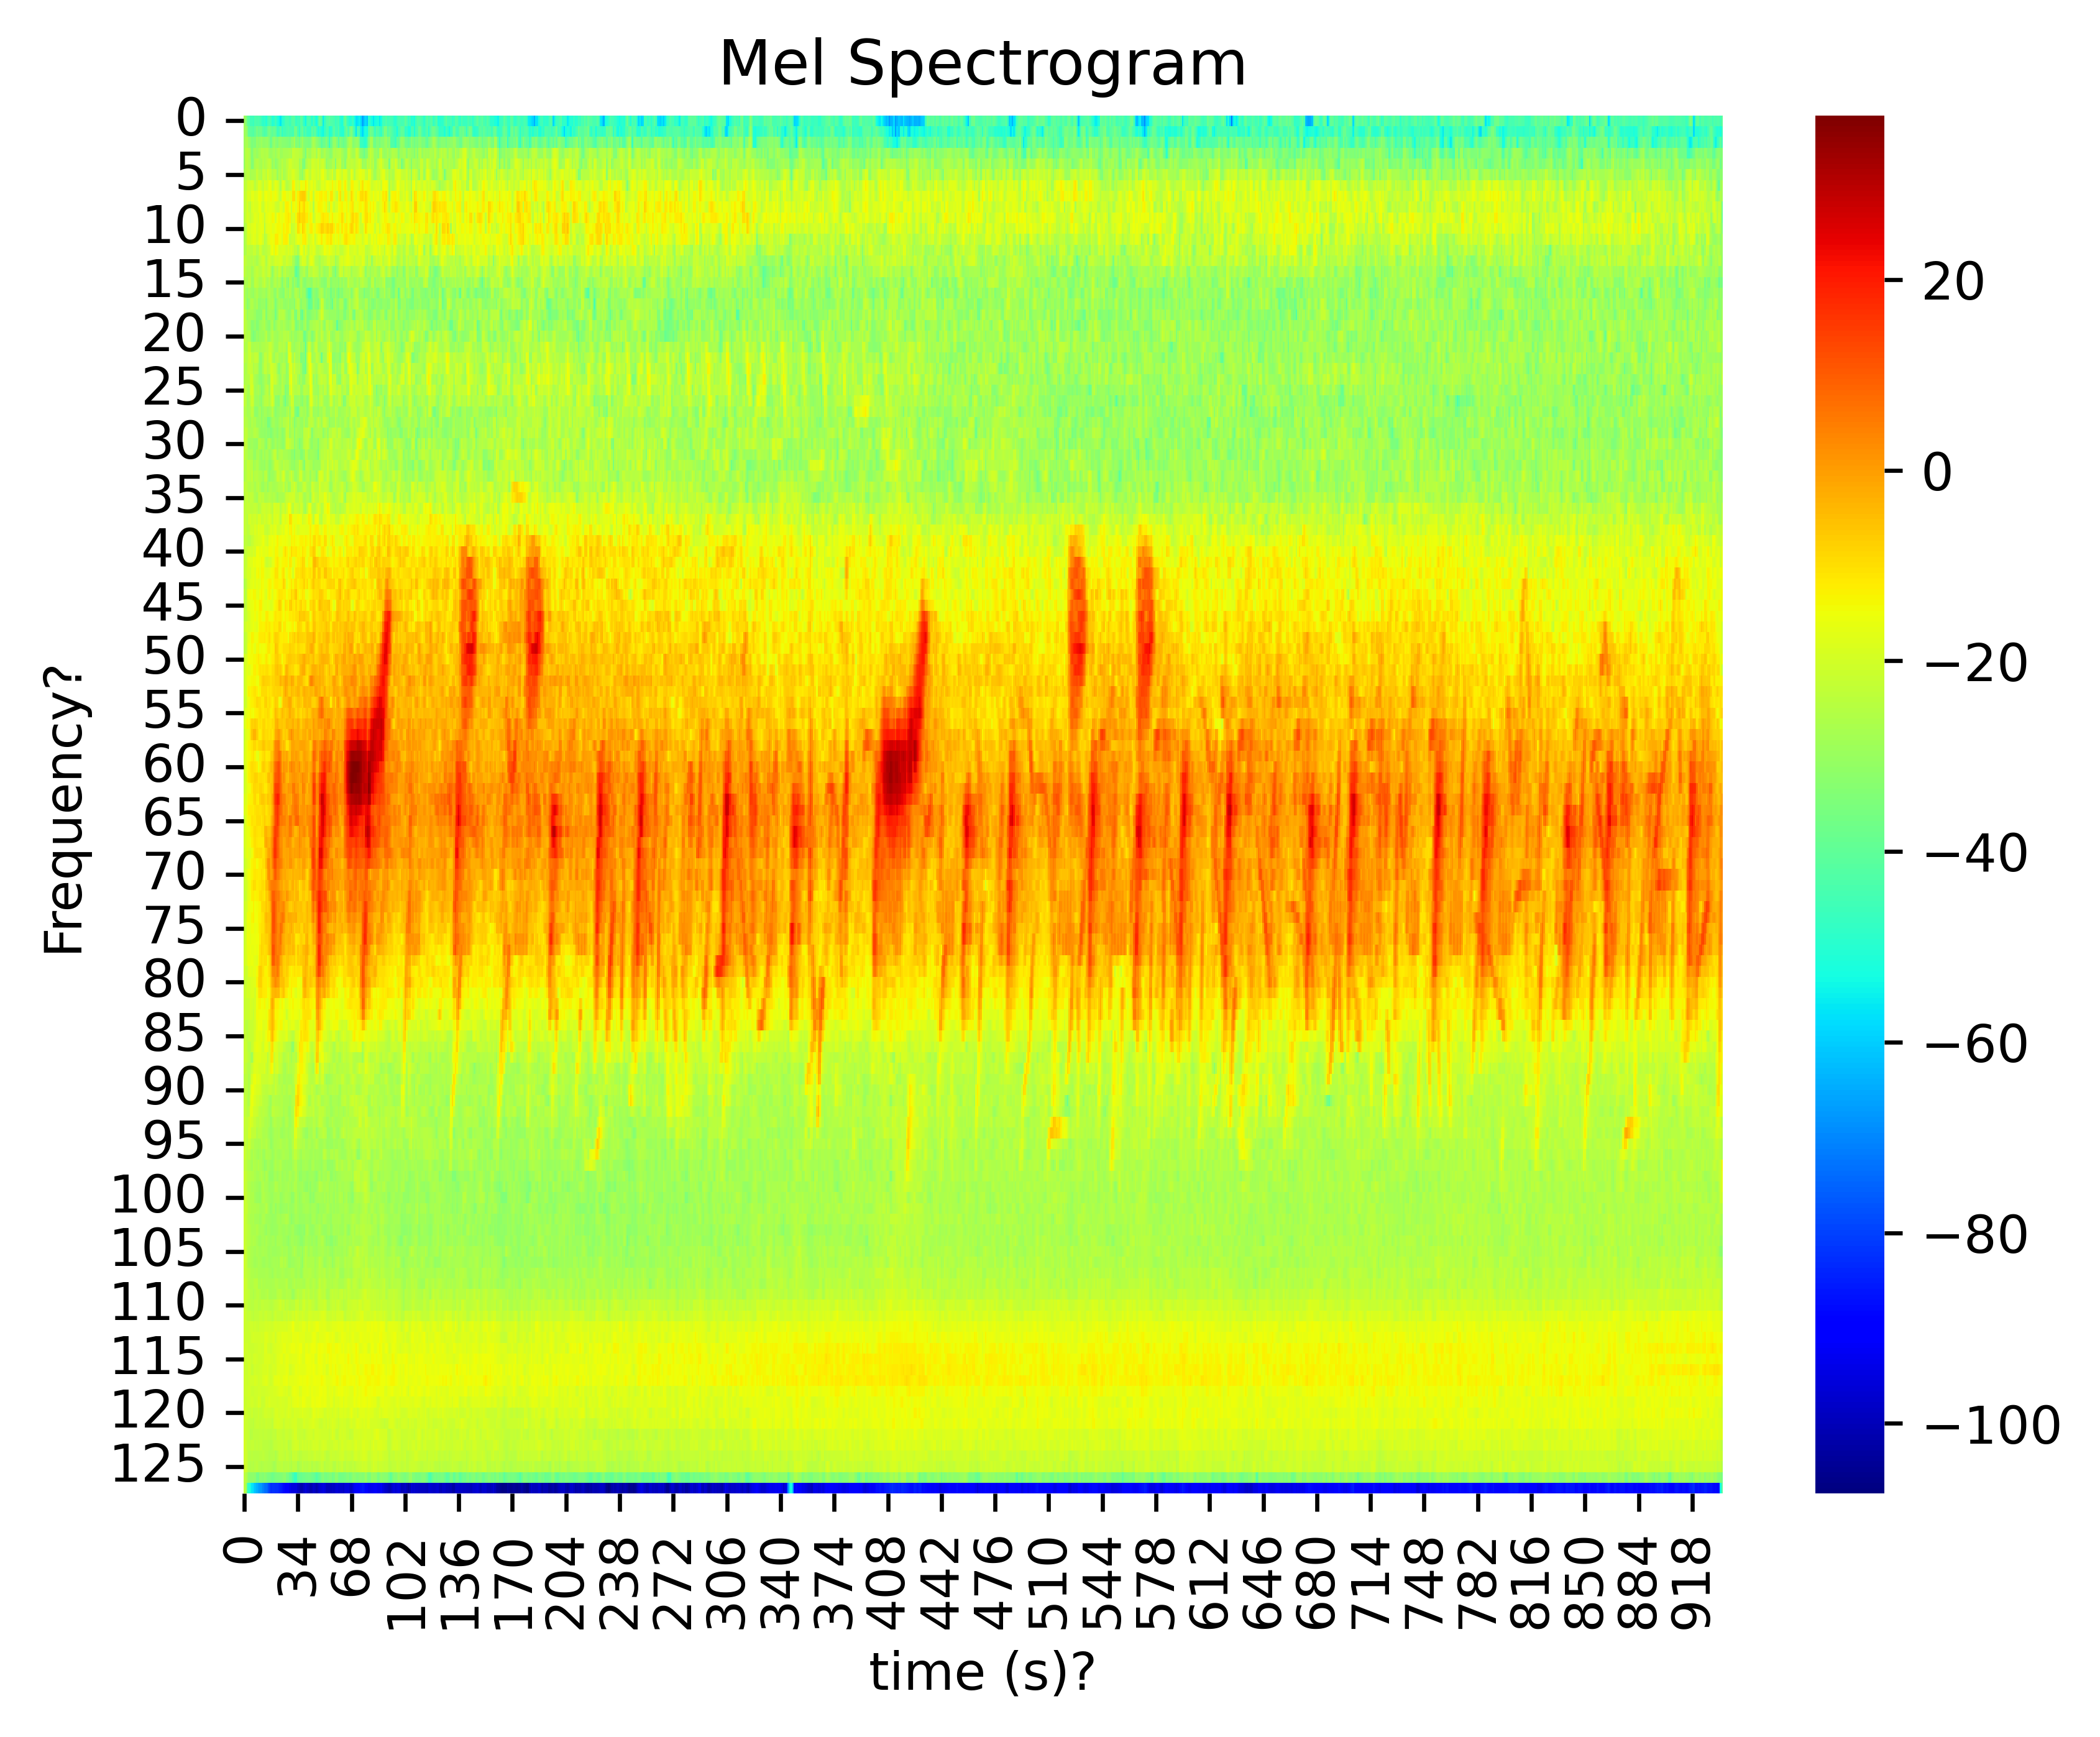

In [61]:
mel_spectrogram = get_melspectrogram(audio_15)

plt.figure()
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
ax = sns.heatmap( mel_spectrogram , cmap = 'jet' )
ax.set_title('Mel Spectrogram')
plt.xlabel('time (s)?') #Ved ikke helt vad dette skal være -Birk
plt.ylabel('Frequency?') #Ved ikke helt vad dette skal være -Birk
plt.show()
